In [1]:
import numpy as np
import time

import seaborn as sns

from src.models.bocs.LinReg import LinReg
from src.models.GPr import GPr
from ngboost import NGBRegressor
from ngboost.distns import LogNormal, Normal, Exponential
from ngboost.scores import CRPS, LogScore
#from xgboost import XGBRegressor

# Learners
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from src.problems.contamination import Contamination
from src.problems.rna import pRNA
from src.problems.bqp import BQP
from src.problems.latin_square import LatinSquare

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from src.models.bnn.bnn_engine import *


# Contamination problem

In [2]:
N = 300
opt = Contamination(n=N, lamda=0.0001)
X = opt.X
y = opt.y
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# BNN

In [10]:
hp = default_hp()
hp.lr = 1e-3
hp.patience = 100
hp.batch_size = 32
hp.epochs = 2000
model = BNN_engine.from_hparams(hp)

In [11]:
model.train(X_train, y_train, X_test, y_test, hp, verbose=True)

  0%|                                                                                                                                                                                  | 0/2000 [00:00<?, ?it/s]/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
 12%|████████████                                                                                            | 231/2000 [00:53<06:50,  4.31it/s, train_R^2=0.803, train_loss=1.99, val_R^2=0.675, val_loss=

Restoring checkpoint at step 131 with best value at 0.712
Early stopped at 131 with val_R^2=0.712


In [12]:
model.predict(X_test)

array([[1.8098211, 1.8098211, 1.8098211, ..., 1.8098211, 1.8098211,
        1.8098211],
       [1.9436257, 1.9436257, 1.9436257, ..., 1.9436257, 1.9436257,
        1.9436257],
       [1.1977806, 1.1977806, 1.1977806, ..., 1.1977806, 1.1977806,
        1.1977806],
       ...,
       [2.5172346, 2.5172346, 2.5172346, ..., 2.5172346, 2.5172346,
        2.5172346],
       [1.4124476, 1.4124476, 1.4124476, ..., 1.4124476, 1.4124476,
        1.4124476],
       [2.5517585, 2.5517585, 2.5517585, ..., 2.5517585, 2.5517585,
        2.5517585]], dtype=float32)

<Axes: >

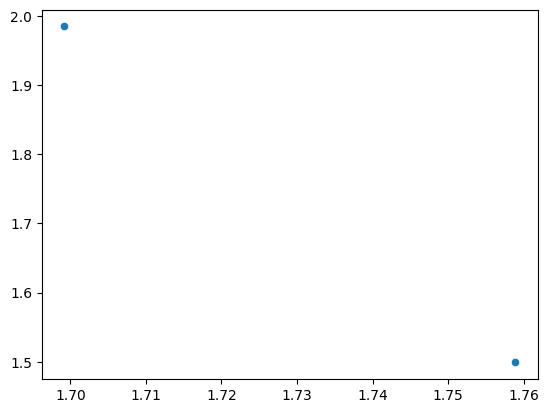

In [6]:
sns.scatterplot(x=y_test, y=y_mu)

## GP

In [12]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))


Test R^2: 1.000
Test RMSE: 0.000 units
Test MAE: 0.000 units


## BOCS

In [8]:
m2 = LinReg(nVars=25, order=2)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Attempt Gibbs 1
Iter Gibbs 0
Iter Gibbs 100
Iter Gibbs 200
Iter Gibbs 300
Iter Gibbs 400
Iter Gibbs 500
Iter Gibbs 600
Iter Gibbs 700
Iter Gibbs 800
Iter Gibbs 900
Iter Gibbs 1000
Iter Gibbs 1100
Iter Gibbs 1200
Iter Gibbs 1300
Iter Gibbs 1400
Iter Gibbs 1500
Iter Gibbs 1600
Iter Gibbs 1700
Iter Gibbs 1800
Iter Gibbs 1900

Test R^2: 0.719
Test RMSE: 0.327 units
Test MAE: 0.266 units


In [11]:
res = m2.sample_pred(X_test)
res.shape

(40, 2000)

## NGBoost - LinCV

In [ ]:
learner = LassoCV(cv=5)
m3 = NGBRegressor(Base=learner)
m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

# RNA problem

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
N = 10
opt = pRNA(n=N)
X = opt.X
y = opt.y
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=1)

<Axes: ylabel='Count'>

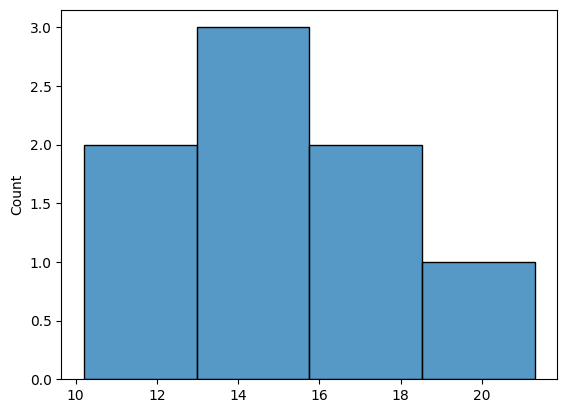

In [18]:
import seaborn as sns
sns.histplot(y_train)

In [19]:
opt.generate_candidate()

array([[3, 2, 2, 2, 3, 3, 1, 2, 1, 1, 3, 3, 0, 1, 3, 0, 2, 3, 0, 0, 0, 0,
        0, 2, 3, 1, 0, 0, 1, 1]])

In [5]:
#scaler.fit(y_train.reshape(-1,1))
#y_train = scaler.transform(y_train.reshape(-1,1)).squeeze()
#y_test  = scaler.transform(y_test.reshape(-1,1)).squeeze()

# BNN

In [5]:
hp = default_hp()
hp.lr = 1e-3
hp.patience = 100
hp.batch_size = 32
hp.epochs = 2000
hp.batch_size = int(X_train.shape[0])
model = BNN_engine.from_hparams(hp)
model.train(X_train, y_train, X_test, y_test, hp, verbose=True)

  0%|                                                                                                                                                                                  | 0/2000 [00:00<?, ?it/s]/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
 62%|████████████████████████████████████████████████████████████████▎                                      | 1248/2000 [01:28<00:53, 14.03it/s, train_R^2=0.482, train_loss=14.7, val_R^2=0.389, val_loss=

Restoring checkpoint at step 1148 with best value at 0.389
Early stopped at 1148 with val_R^2=0.389


In [ ]:
y_pred = model.predict(X_test)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## NGBoost - LinCV

In [7]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
m3 = NGBRegressor(Base=dec, learning_rate=0.05, verbose_eval=5, 
                  n_estimators=100, Dist=Normal)
m3.fit(X_train, y_train, X_test, y_test)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

[iter 0] loss=2.5857 val_loss=2.6021 scale=1.0000 norm=2.6633
[iter 5] loss=2.5081 val_loss=2.5845 scale=1.0000 norm=2.5389
[iter 10] loss=2.4555 val_loss=2.5714 scale=1.0000 norm=2.4354
[iter 15] loss=2.4082 val_loss=2.5588 scale=1.0000 norm=2.3420
[iter 20] loss=2.3644 val_loss=2.5430 scale=1.0000 norm=2.2582
[iter 25] loss=2.3207 val_loss=2.5303 scale=1.0000 norm=2.1791
[iter 30] loss=2.2807 val_loss=2.5286 scale=1.0000 norm=2.1089
[iter 35] loss=2.2374 val_loss=2.5258 scale=1.0000 norm=2.0350
[iter 40] loss=2.1950 val_loss=2.5223 scale=1.0000 norm=1.9676
[iter 45] loss=2.1553 val_loss=2.5278 scale=1.0000 norm=1.9086
[iter 50] loss=2.1171 val_loss=2.5346 scale=1.0000 norm=1.8527
[iter 55] loss=2.0790 val_loss=2.5494 scale=1.0000 norm=1.7980
[iter 60] loss=2.0399 val_loss=2.5722 scale=1.0000 norm=1.7434
[iter 65] loss=2.0032 val_loss=2.5981 scale=1.0000 norm=1.6943
[iter 70] loss=1.9684 val_loss=2.6313 scale=1.0000 norm=1.6502
[iter 75] loss=1.9331 val_loss=2.6607 scale=1.0000 norm=1

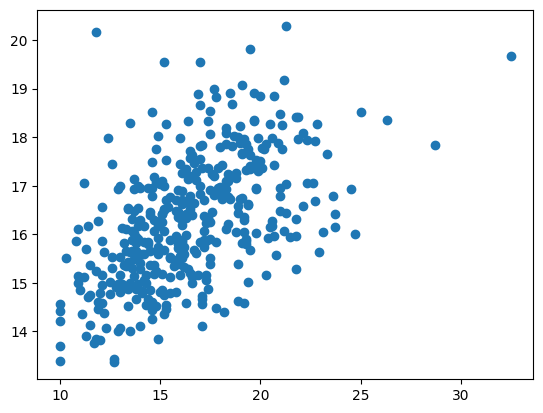

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [13]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Metal device set to: Apple M2


2023-04-24 16:56:16.622029: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Test R^2: 0.334
Test RMSE: 2.059 units
Test MAE: 1.601 units


In [16]:
y_pred = m1.pred_dist(X_test)
y_pred.sample(10)

array([[16.27849141, 15.92948684],
       [13.64263037, 15.48641084],
       [15.59252017, 15.81486588],
       [16.12565917, 15.93420897],
       [17.03893087, 15.31132437],
       [17.12331903, 15.60267702],
       [16.88283213, 17.52233407],
       [16.49320817, 13.05021725],
       [15.15547614, 14.79908458],
       [15.30745874, 13.94815789]])

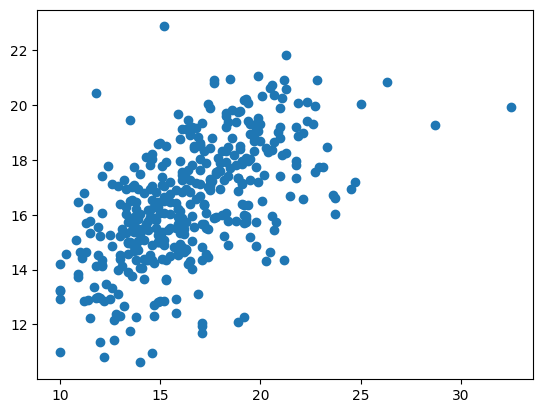

In [10]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=90, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Attempt Gibbs 1
Iter Gibbs 0
Fast Small Sampler
error during Gibbs sampling. Trying again.
Attempt Gibbs 1
Iter Gibbs 0
Fast Small Sampler


# BQP problem

In [ ]:
N = 200
opt = BQP(n=N)
X = opt.X
y = opt.y + 10.0
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)

## NGBoost - LinCV

In [ ]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=xgb, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [ ]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

# Latin Square problem

In [31]:
N = 1000
opt = LatinSquare(n=N)
test_set_size = 0.2
X = opt.X
y = opt.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)


Test R^2: -0.062
Test RMSE: 0.061 units
Test MAE: 0.050 units


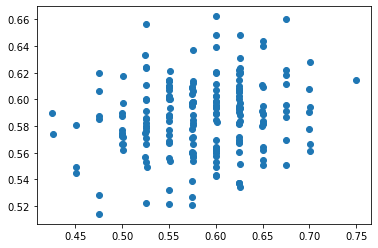

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## NGBoost - LinCV

In [33]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=lin, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

[iter 0] loss=-1.4845 val_loss=0.0000 scale=0.5000 norm=0.2465
[iter 5] loss=-1.5363 val_loss=0.0000 scale=0.5000 norm=0.2239
[iter 10] loss=-1.5550 val_loss=0.0000 scale=0.5000 norm=0.2202
[iter 15] loss=-1.5639 val_loss=0.0000 scale=0.2500 norm=0.1109
[iter 20] loss=-1.5662 val_loss=0.0000 scale=0.2500 norm=0.1111
[iter 25] loss=-1.5674 val_loss=0.0000 scale=0.0625 norm=0.0278

Test R^2: -0.101
Test RMSE: 0.062 units
Test MAE: 0.050 units


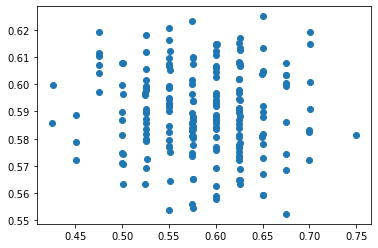

In [34]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [35]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))


Test R^2: 0.035
Test RMSE: 0.058 units
Test MAE: 0.047 units


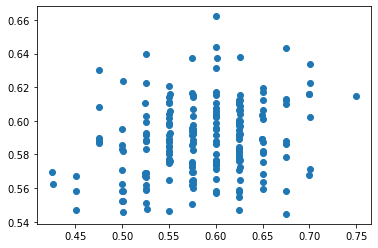

In [36]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))